# GROUP 23 PROJECT


## Structure-from-Motion (SfM) Pipeline  
### Week 1 till Week 3


## WEEK 1:

Importing required libraries:

In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import pillow_heif

Project Directory Setup

In [2]:
frames_dir = "images"
start_index, end_index = 1, 26
image_ext = ".HEIC"
output_dir = "outputs"
os.makedirs(output_dir, exist_ok=True)

Loading all the images:

In [3]:
def image_loading(path):
    ext = os.path.splitext(path)[1].lower()
    if ext in ['.heic', '.heif']:
        heif_file = pillow_heif.read_heif(path)
        img = Image.frombytes(heif_file.mode, heif_file.size, heif_file.data, "raw")
        img_cv = cv2.cvtColor(np.array(img), cv2.COLOR_RGB2BGR)
    else:
        img_cv = cv2.imread(path)
    return img_cv


 Feature Detaction through SIFT:

In [4]:
def feature_detector(method='SIFT', nfeatures=4000):
    method = method.upper()
    if method == 'SIFT':
        detector = cv2.SIFT_create(
            nfeatures=nfeatures,
            contrastThreshold=0.03,
            edgeThreshold=10,
            sigma=1.6
        )
        return detector, 'SIFT'
    else:
        detector = cv2.ORB_create(nfeatures=nfeatures)
        return detector, 'ORB'


Feature Extraction from Image (Grayscale Conversion):

In [5]:
def detect_features(detector, image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    kp, desc = detector.detectAndCompute(gray, None)
    return kp, desc

Filtering Keypoint Matches Using Ratio Test:

In [6]:
def keypoints_matching_filtering(descriptor_1, descriptor_2, method_name='SIFT', ratio=0.7):
    if descriptor_1 is None or descriptor_2 is None:
        return []

    if method_name == 'SIFT':
        if descriptor_1.dtype != np.float32:
            descriptor_1 = descriptor_1.astype(np.float32)
            descriptor_2 = descriptor_2.astype(np.float32)
        index_parameters = dict(algorithm=1, trees=5)
        search_parameters = dict(checks=50)
        matcher = cv2.FlannBasedMatcher(index_parameters, search_parameters)
        knn_matches = matcher.knnMatch(descriptor_1, descriptor_2, k=2)

    good = []
    for m_n in knn_matches:
        if len(m_n) < 2:
            continue
        m, n = m_n
        if m.distance < ratio * n.distance:
            good.append(m)
    return good

Visualizing and Saving Keypoint Matches:

In [7]:
def keypoints_visualize_Nsave(image_1, image_2, keypoint_1, keypoint_2, matches, label):
    matched_img = cv2.drawMatches(
        image_1, keypoint_1, image_2, keypoint_2, matches, None,
        flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS
    )
    plt.figure(figsize=(14, 7))
    plt.imshow(cv2.cvtColor(matched_img, cv2.COLOR_BGR2RGB))
    plt.title(f"Filtered Matches ({label}) - {len(matches)} good matches")
    plt.axis('off')
    plt.show()

    path_output = os.path.join(output_dir, f"matches_{label}.png")
    cv2.imwrite(path_output, matched_img)

Processing Image Sequence and Counting Good Matches:

In [8]:
detector, method_name = feature_detector('SIFT', nfeatures=4000)
match_counts = []

for i in range(start_index, end_index):
    path_1 = os.path.join(frames_dir, f"{i:02d}{image_ext}")
    path_2 = os.path.join(frames_dir, f"{i+1:02d}{image_ext}")

    image_1 = image_loading(path_1)
    image_2 = image_loading(path_2)
    keypoint_1, descriptor_1 = detect_features(detector, image_1)
    keypoint_2, descriptor_2 = detect_features(detector, image_2)
    matches = keypoints_matching_filtering(descriptor_1, descriptor_2, method_name=method_name, ratio=0.7)
    num_matches = len(matches)

    print(f"img{i} - img{i+1}: {num_matches} good matches")
    match_counts.append((i, num_matches, keypoint_1, keypoint_2,
                     descriptor_1, descriptor_2,
                     matches, image_1, image_2))


img1 - img2: 910 good matches
img2 - img3: 223 good matches
img3 - img4: 633 good matches
img4 - img5: 351 good matches
img5 - img6: 172 good matches
img6 - img7: 561 good matches
img7 - img8: 716 good matches
img8 - img9: 720 good matches
img9 - img10: 713 good matches
img10 - img11: 1375 good matches
img11 - img12: 1449 good matches
img12 - img13: 879 good matches
img13 - img14: 1429 good matches
img14 - img15: 518 good matches
img15 - img16: 984 good matches
img16 - img17: 728 good matches
img17 - img18: 670 good matches
img18 - img19: 1163 good matches
img19 - img20: 724 good matches
img20 - img21: 405 good matches
img21 - img22: 331 good matches
img22 - img23: 219 good matches
img23 - img24: 181 good matches
img24 - img25: 283 good matches
img25 - img26: 490 good matches


Ranking Image Pairs by Match Strength:

In [9]:
match_counts.sort(key=lambda x: x[1], reverse=True)
print("\nTop 5 image pairs with strongest overlap:")
for index, count, *_ in match_counts[:5]:
    print(f"IMG_{index} - IMG_{index+1}: {count} matches")


Top 5 image pairs with strongest overlap:
IMG_11 - IMG_12: 1449 matches
IMG_13 - IMG_14: 1429 matches
IMG_10 - IMG_11: 1375 matches
IMG_18 - IMG_19: 1163 matches
IMG_15 - IMG_16: 984 matches


Visualizing the Top 3 Strongest Match Pairs:


 Visualizing top 3 match pairs


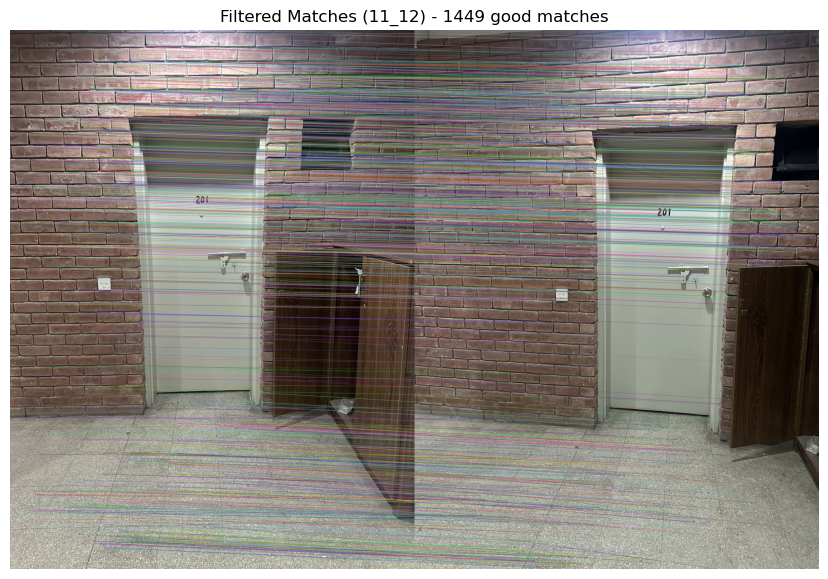

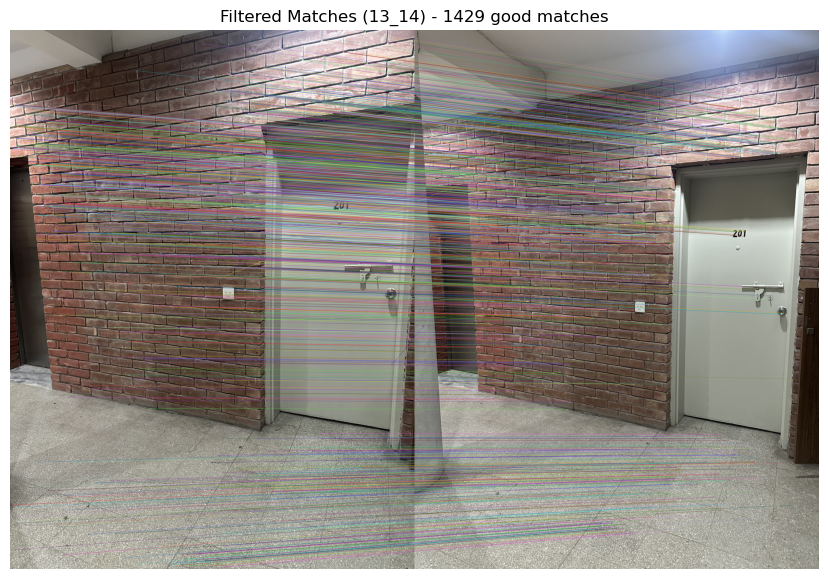

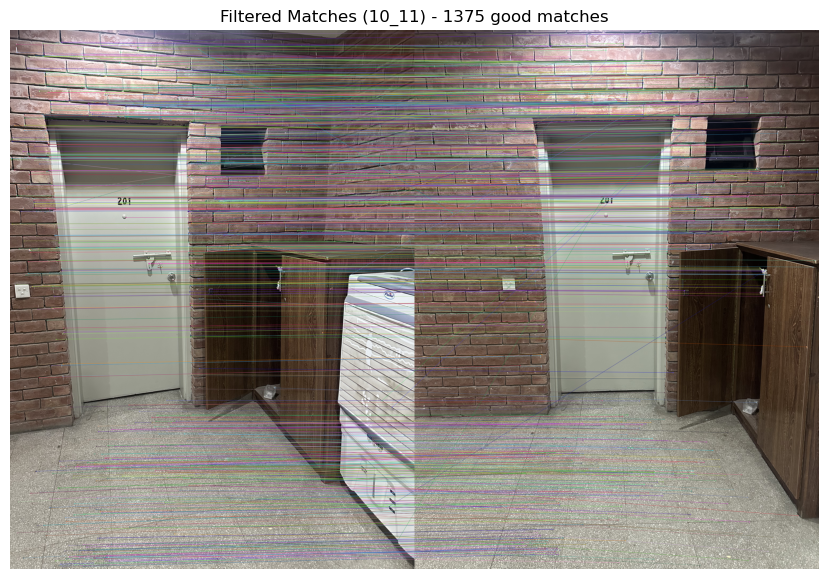

In [10]:
print("\n Visualizing top 3 match pairs")
for index, count, keypoint_1, keypoint_2, descriptor_1, descriptor_2, matches, image_1, image_2 in match_counts[:3]:
    label = f"{index}_{index+1}"
    keypoints_visualize_Nsave(image_1, image_2, keypoint_1, keypoint_2, matches, label)

## Week 2: Two-View Reconstruction

Selecting the Best Image Pair and Extracting Matched Feature Points:

In [11]:
best_index, _, kp1, kp2, des1, des2, matches, img1_best, img2_best = match_counts[0]

print(f"Using image pair: img{best_index} and img{best_index+1}")
print("Total matches:", len(matches))

pts1 = np.float32([kp1[m.queryIdx].pt for m in matches])
pts2 = np.float32([kp2[m.trainIdx].pt for m in matches])


Using image pair: img11 and img12
Total matches: 1449


Preparing Matched Keypoint Arrays for Estimation:

In [12]:
print("Week-2 image 1:", img1_best.shape)
print("Week-2 image 2:", img2_best.shape)


Week-2 image 1: (4032, 3024, 3)
Week-2 image 2: (4032, 3024, 3)


In [13]:
pts1 = np.float32([kp1[m.queryIdx].pt for m in matches])
pts2 = np.float32([kp2[m.trainIdx].pt for m in matches])

### Constructing Camera Intrinsic Matrix (K)
- `fx = fy = image_width`
- `cx = w/2`
- `cy = h/2`


In [14]:
h, w = img1_best.shape[:2]
f = w  # simplified assumption

K = np.array([
    [f, 0, w/2],
    [0, f, h/2],
    [0, 0, 1]
])

print("Intrinsic Matrix K:\n", K)


Intrinsic Matrix K:
 [[3.024e+03 0.000e+00 1.512e+03]
 [0.000e+00 3.024e+03 2.016e+03]
 [0.000e+00 0.000e+00 1.000e+00]]


### Estimating the Essential Matrix Using RANSAC

In [15]:
E, mask_E = cv2.findEssentialMat(
    pts1, pts2, K,
    cv2.RANSAC, prob=0.999, threshold=1.0
)

print("Estimated Essential Matrix:\n", E)
print("Inliers:", np.sum(mask_E))


Estimated Essential Matrix:
 [[-0.00389752 -0.30337007 -0.05835605]
 [ 0.4160491   0.00233623 -0.56968004]
 [ 0.07440145  0.63278582  0.03090067]]
Inliers: 778


Recovering Camera Rotation and Translation

In [16]:
_, R, t, mask_pose = cv2.recoverPose(E, pts1, pts2, K)

print("Recovered Rotation R:\n", R)
print("\nRecovered Translation t:\n", t)

Recovered Rotation R:
 [[ 0.98222858 -0.04754514  0.18156674]
 [ 0.04191775  0.99851802  0.03470827]
 [-0.18294787 -0.02648058  0.98276592]]

Recovered Translation t:
 [[-0.89949539]
 [ 0.06873626]
 [-0.4314897 ]]


### Triangulating 3D Points from Two Views

In [17]:
P0 = K @ np.hstack((np.eye(3), np.zeros((3,1))))
P1 = K @ np.hstack((R, t))

pts4D = cv2.triangulatePoints(P0, P1, pts1.T, pts2.T)
pts3D = (pts4D[:3] / pts4D[3]).T

print("Triangulated 3D points:", pts3D.shape)


Triangulated 3D points: (1449, 3)


In [18]:
valid_mask = np.isfinite(pts3D).all(axis=1)
pts3D = pts3D[valid_mask]

print("Valid 3D points:", pts3D.shape)


Valid 3D points: (1449, 3)


### Extracting Descriptors of Inlier Matched Points

In [19]:
desc_img1_matches = np.array([
    des1[matches[i].queryIdx] 
    for i in range(len(matches)) 
    if valid_mask[i]
])

print("Descriptor count (from img1):", desc_img1_matches.shape)

Descriptor count (from img1): (1449, 128)


### Visualize the 3D Point Cloud

- **3D view**  
- **2D projection (X vs Z)**  


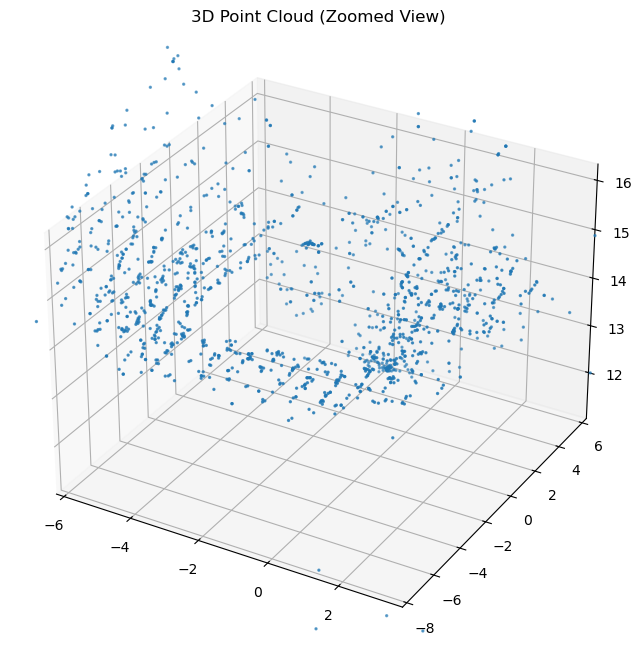

In [20]:
from mpl_toolkits.mplot3d import Axes3D

# Compute bounds
x_min, x_max = np.percentile(pts3D[:,0], [5, 95])
y_min, y_max = np.percentile(pts3D[:,1], [5, 95])
z_min, z_max = np.percentile(pts3D[:,2], [5, 95])

fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(pts3D[:,0], pts3D[:,1], pts3D[:,2], s=2)

# Apply zoomed-in limits
ax.set_xlim(x_min, x_max)
ax.set_ylim(y_min, y_max)
ax.set_zlim(z_min, z_max)

ax.set_title("3D Point Cloud (Zoomed View)")
plt.show()


- ### FRONT VIEW

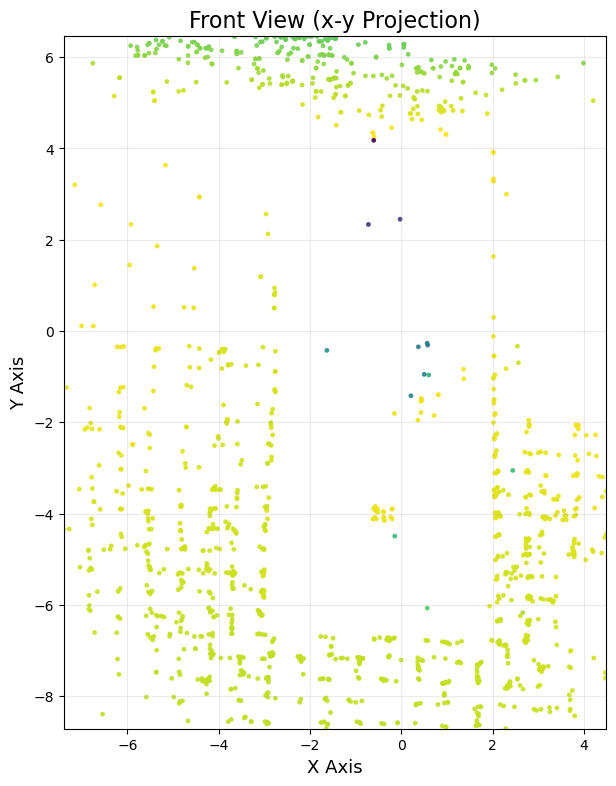

In [21]:
x = pts3D[:, 0]
y = pts3D[:, 1]

x_min, x_max = np.percentile(x, [2, 98])
y_min, y_max = np.percentile(y, [2, 98])

mask = (x >= x_min) & (x <= x_max) & (y >= y_min) & (y <= y_max)
pts_filtered = pts3D[mask]

x_f = pts_filtered[:, 0]
y_f = pts_filtered[:, 1]
z_f = pts_filtered[:, 2]

plt.figure(figsize=(9, 9))
plt.scatter(
    x_f, y_f,
    s=6,
    c=z_f,
    cmap='viridis',
    alpha=0.85
)

plt.title("Front View (x-y Projection)", fontsize=16)
plt.xlabel("X Axis", fontsize=13)
plt.ylabel("Y Axis", fontsize=13)

plt.xlim(x_f.min(), x_f.max())
plt.ylim(y_f.min(), y_f.max())

plt.gca().set_aspect('equal', 'box')

plt.grid(alpha=0.25)
plt.show()


### 7. Exporting the Point Cloud (PLY format)

In [22]:
import open3d as o3d

pcd = o3d.geometry.PointCloud()
pcd.points = o3d.utility.Vector3dVector(pts3D)

ply_path = os.path.join(output_dir, "two_view_cloud.ply")
o3d.io.write_point_cloud(ply_path, pcd)

print("Saved PLY:", ply_path)


Saved PLY: outputs/two_view_cloud.ply


# Week 3 — Incremental SfM & Refinement


In [23]:
from scipy.optimize import least_squares
from PIL import Image, ExifTags

Loading Images:

In [24]:
def _open_image_with_exif(path):
    ext = path.lower().split('.')[-1]
    if ext in ['heic', 'heif']:
        heif_file = pillow_heif.read_heif(path)
        img = Image.frombytes(heif_file.mode, heif_file.size, heif_file.data, 'raw')
        if 'exif' in heif_file.info:
            img.info['exif'] = heif_file.info['exif']
        return img
    else:
        return Image.open(path)


Extracting EXIF data into a Dictionary:

In [25]:
def _extract_exif_dict(img):
    if not hasattr(img, "_getexif"):
        return None
    raw = img._getexif()
    if not raw:
        return None
    exif_data = {}
    for k, v in raw.items():
        if k in ExifTags.TAGS:
            tag_name = ExifTags.TAGS[k]
        else:
            tag_name = k
        exif_data[tag_name] = v

    return exif_data



Computing Focal Length in Pixels:

In [26]:

def _focal_from_exif(exif_data, width):
    """Return focal length in pixels or None."""
    focal_px = None

    if exif_data:
        if 'FocalLengthIn35mmFilm' in exif_data:
            f_35 = exif_data['FocalLengthIn35mmFilm']
            fp = f_35 / 36.0
            focal_px = fp * width
        elif 'FocalLength' in exif_data:
            f_mm = exif_data['FocalLength']
            if isinstance(f_mm, tuple):
                first = float(f_mm[0]) 
                next = float(f_mm[1])
                f_mm = first / next
    return focal_px


 Building Camera Intrinsic Matrix (K):

In [27]:
def get_intrinsics_from_exif(path, shape=None, ff=1.0):
    img = _open_image_with_exif(path)
    w, h = img.size
    exif_data = _extract_exif_dict(img)
    focal_px = _focal_from_exif(exif_data, w)
    if focal_px is None:
        focal_px = w * ff
    K = np.array([[focal_px, 0, w / 2.0],
                  [0, focal_px, h / 2.0],
                  [0, 0, 1]], dtype=np.float64)
    return K

Preprocessing All Images: Loading and Extracting SIFT Features:

In [28]:
camera_poses = {}
points_3d = []
points_colors = []
map_2d_3d = {}
image_dir = "images"
import os

image_files = []
for filename in os.listdir(image_dir):
    lower_name = filename.lower()
    if lower_name.endswith(".heic") or lower_name.endswith(".jpg") or lower_name.endswith(".png"):
        image_files.append(filename)
image_files.sort()

detector = cv2.SIFT_create(nfeatures=5000)
container = {} 

print(f"There are {len(image_files)} images.")
print("Preprocessing...")
idx = 0
for fname in image_files:
    path = os.path.join(image_dir, fname)
    img  = image_loading(path)
    kp, desc = detect_features(detector, img)
    info = {}
    info['kp']   = kp
    info['desc'] = desc
    info['img']  = img
    info['name'] = fname
    container[idx] = info
    idx += 1

print("Preprocessing done.")

There are 29 images.
Preprocessing...
Preprocessing done.


### Bootstrapping Structure-from-Motion

In [29]:
print(f"Bootstrap with Images 11 and 12...")

kp1 = container[11]['kp']
desc1 = container[11]['desc']
kp2 = container[12]['kp']
desc2 = container[12]['desc']
image_info = container[11]
filename = image_info['name']
img1_path = os.path.join(image_dir, filename)

K = get_intrinsics_from_exif(img1_path, shape=container[11]['img'].shape)
print("Intrinsic Matrix K:\n", K)

Bootstrap with Images 11 and 12...
Intrinsic Matrix K:
 [[3.024e+03 0.000e+00 1.512e+03]
 [0.000e+00 3.024e+03 2.016e+03]
 [0.000e+00 0.000e+00 1.000e+00]]


Matching Descriptors and Gathering 2D Point Correspondences

In [30]:
matches = keypoints_matching_filtering(desc1, desc2)

pts1_list = []
pts2_list = []

# Collect corresponding 2D points from both images
for m in matches:
    pt1 = kp1[m.queryIdx].pt
    pt2 = kp2[m.trainIdx].pt
    pts1_list.append(pt1)
    pts2_list.append(pt2)

num_points = len(pts1_list)
pts1 = np.zeros((num_points, 2), dtype=np.float32)
pts2 = np.zeros((num_points, 2), dtype=np.float32)

for i in range(num_points):
    pts1[i, 0] = pts1_list[i][0]
    pts1[i, 1] = pts1_list[i][1]
    pts2[i, 0] = pts2_list[i][0]
    pts2[i, 1] = pts2_list[i][1]


Estimating Essential Matrix and Selecting Inlier Matches

In [31]:
E, mask_E = cv2.findEssentialMat(pts1, pts2, K, method=cv2.RANSAC, prob=0.999, threshold=1.0)

# Collect indices of inlier matches from the mask
mask_flat = mask_E.ravel()
inlier_indices = []
for i in range(len(mask_flat)):
    if mask_flat[i] == 1:
        inlier_indices.append(i)

# Keep only inliers
pts1_in_list = []
pts2_in_list = []
matches_in   = []
for idx in inlier_indices:
    pts1_in_list.append(pts1[idx])
    pts2_in_list.append(pts2[idx])
    matches_in.append(matches[idx])
pts1_in = np.array(pts1_in_list, dtype=np.float32)
pts2_in = np.array(pts2_in_list, dtype=np.float32)

Recovering Relative Camera Pose and Selecting Triangulation Inliers:

In [32]:
_, R, t, mask_pose = cv2.recoverPose(E, pts1_in, pts2_in, K)

R1 = np.eye(3)
t1 = np.zeros((3, 1))
Rt1 = np.concatenate((R1, t1), axis=1)
P1 = np.dot(K, Rt1)
camera_index_1 = 11
camera_poses[camera_index_1] = (R1, t1)

R2 = R
t2 = t
Rt2 = np.concatenate((R2, t2), axis=1)
P2 = np.dot(K, Rt2)
camera_index_2 = 12
camera_poses[camera_index_2] = (R2, t2)

# Use pose inlier mask to decide which points to triangulate
mask_flat_pose = mask_pose.ravel()

tri_indices = []
for i in range(len(mask_flat_pose)):
    if mask_flat_pose[i] == 255:
        tri_indices.append(i)

pts1_tri_list = []
pts2_tri_list = []
matches_final = []

for idx in tri_indices:
    pts1_tri_list.append(pts1_in[idx])
    pts2_tri_list.append(pts2_in[idx])
    matches_final.append(matches_in[idx])

pts1_tri = np.array(pts1_tri_list, dtype=np.float32)
pts2_tri = np.array(pts2_tri_list, dtype=np.float32)

Triangulating Initial 3D Points from Two Views:

In [33]:
pts4D = cv2.triangulatePoints(P1, P2, pts1_tri.T, pts2_tri.T)

num_points = pts4D.shape[1]
pts3D_init_list = []

for i in range(num_points):
    x = pts4D[0, i]
    y = pts4D[1, i]
    z = pts4D[2, i]
    w = pts4D[3, i]

    if w != 0:
        pts3D_init_list.append([x / w, y / w, z / w])
    else:
        pts3D_init_list.append([x, y, z])

pts3D_init = np.array(pts3D_init_list, dtype=np.float64)

Creating Initial 3D Point Cloud with Colors and 2D–3D Mappings:

In [34]:
img1_color = container[11]['img']

num_points = len(pts3D_init)
img_height = img1_color.shape[0]
img_width  = img1_color.shape[1]

index = 0
while index < num_points:
    pt3d = pts3D_init[index]
    z_value = pt3d[2]

    # Simple depth filter for 3D points
    if z_value < 0 or z_value > 1000:
        index += 1
        continue

    new_pt_idx = len(points_3d)
    points_3d.append(pt3d)

    pt2d = pts1_tri[index]
    pt2d_int = pt2d.astype(int)

    x_pixel = pt2d_int[0]
    y_pixel = pt2d_int[1]
    cx = np.clip(x_pixel, 0, img_width  - 1)
    cy = np.clip(y_pixel, 0, img_height - 1)
    color_bgr = img1_color[cy, cx]
    color_rgb = color_bgr[::-1]

    points_colors.append(color_rgb)

    # Record 2D–3D correspondences for both cameras
    m = matches_final[index]
    key_cam1 = (11, m.queryIdx)
    map_2d_3d[key_cam1] = new_pt_idx
    key_cam2 = (12, m.trainIdx)
    map_2d_3d[key_cam2] = new_pt_idx

    index += 1

print(f"Bootstrap complete. Initial 3D points: {len(points_3d)}")

Bootstrap complete. Initial 3D points: 685


### Phase 2: Incremental SfM – Initialization

Steps:
1.  Separating 2D–3D Correspondences and Triangulation Matches
2. Preparing 2D–3D Arrays for PnP Estimation
3. Localizing the Current Camera Using PnP
4. Building Projection Matrices for Previous and Current Cameras
5. Preparing 2D Keypoints for Triangulation
6. Triangulating New 3D Points Between Views
7. Adding New Triangulated Points to the Global 3D Map
8. Running the Incremental SfM Pipeline Loop


In [35]:
# Phase 2: Incremental SfM
start_index   = 12
total_images  = len(image_files)

# Loop over all images starting from index 12
while start_index < total_images:
    prev_idx = start_index - 1
    curr_idx = start_index
    start_index = start_index + 1

    print(f"Matching Image {curr_idx} with {prev_idx}")

    # Get keypoints and descriptors for previous and current images
    kp_prev = container[prev_idx]['kp']
    desc_prev = container[prev_idx]['desc']
    kp_curr = container[curr_idx]['kp']
    desc_curr = container[curr_idx]['desc']

    # Match features between previous and current image
    matches = keypoints_matching_filtering(desc_prev, desc_curr)
    
    # Separate matches that already have 3D points from those that need triangulation
    object_points = []
    image_points = []
    matches_for_triangulation = []
    num_matches = len(matches)
    index = 0

    while index < num_matches:
        current_match = matches[index]
        key_prev_index = prev_idx
        key_feature_index = current_match.queryIdx
        key = (key_prev_index, key_feature_index)

        # If this feature was seen before, we already have a 3D point for it
        if key in map_2d_3d:
            pt3d_idx = map_2d_3d[key]
            pt3d = points_3d[pt3d_idx]
            object_points.append(pt3d)

            feature_index_curr = current_match.trainIdx
            kp_curr_point = kp_curr[feature_index_curr].pt
            image_points.append(kp_curr_point)
        else:
            # Otherwise, keep it for triangulation later
            matches_for_triangulation.append(current_match)

        index += 1

        num_obj_points = len(object_points)
    num_img_points = len(image_points)

    # Convert 3D–2D lists into arrays for PnP
    obj_array = np.zeros((num_obj_points, 3), dtype=np.float32)
    img_array = np.zeros((num_img_points, 2), dtype=np.float32)

    for j in range(num_obj_points):
        obj_array[j, 0] = object_points[j][0]
        obj_array[j, 1] = object_points[j][1]
        obj_array[j, 2] = object_points[j][2]

    for k in range(num_img_points):
        img_array[k, 0] = image_points[k][0]
        img_array[k, 1] = image_points[k][1]

    object_points = obj_array
    image_points  = img_array

    print(f"Found {len(object_points)} 2D-3D correspondences for PnP.")
    
    # Need enough correspondences to run PnP
    if len(object_points) < 8:
        continue
        
    # Estimate pose of current camera with PnP + RANSAC
    retval, rvec, tvec, inliers = cv2.solvePnPRansac(object_points, image_points, K, None)
    if not retval:
        continue

    R_curr, _ = cv2.Rodrigues(rvec)
    t_curr = tvec
    camera_poses[curr_idx] = (R_curr, t_curr)
    print(f"Camera {curr_idx} localized.")

    # Build projection matrices for previous and current cameras
    R_prev, t_prev = camera_poses[prev_idx]
    Rt_prev = np.concatenate((R_prev, t_prev), axis=1)
    P_prev = np.dot(K, Rt_prev)
    Rt_curr = np.concatenate((R_curr, t_curr), axis=1)
    P_curr = np.dot(K, Rt_curr)

    # Prepare points and matches for triangulation
    pts_prev_tri = []
    pts_curr_tri = []
    tri_matches = []
    
    num_tri_matches = len(matches_for_triangulation)

    for l in range(num_tri_matches):
        current_match = matches_for_triangulation[l]

        prev_feature_idx = current_match.queryIdx
        curr_feature_idx = current_match.trainIdx

        prev_point = kp_prev[prev_feature_idx].pt
        curr_point = kp_curr[curr_feature_idx].pt

        pts_prev_tri.append(prev_point)
        pts_curr_tri.append(curr_point)
        tri_matches.append(current_match)

    # Only triangulate if we actually have something
    if len(pts_prev_tri) > 0:
        num_prev = len(pts_prev_tri)
        num_curr = len(pts_curr_tri)

        prev_array = np.zeros((num_prev, 2), dtype=np.float32)
        curr_array = np.zeros((num_curr, 2), dtype=np.float32)

        # Copy previous image points into array
        idxx = 0
        while idxx < num_prev:
            prev_array[idxx, 0] = float(pts_prev_tri[idxx][0])
            prev_array[idxx, 1] = float(pts_prev_tri[idxx][1])
            idxx += 1

        # Copy current image points into array
        j = 0
        while j < num_curr:
            curr_array[j, 0] = float(pts_curr_tri[j][0])
            curr_array[j, 1] = float(pts_curr_tri[j][1])
            j += 1

        pts_prev_tri = prev_array
        pts_curr_tri = curr_array

        # Triangulate new 3D points between previous and current view
        pts4D = cv2.triangulatePoints(P_prev, P_curr, pts_prev_tri.T, pts_curr_tri.T)
        num_points = pts4D.shape[1]
        pts_list = []

        index = 0
        while index < num_points:
            x = pts4D[0, index]
            y = pts4D[1, index]
            z = pts4D[2, index]
            w = pts4D[3, index]

            if w != 0:
                x_norm = x / w
                y_norm = y / w
                z_norm = z / w
            else:
                x_norm = x
                y_norm = y
                z_norm = z

            pts_list.append([x_norm, y_norm, z_norm])
            index = index + 1

        new_pts3D = np.array(pts_list, dtype=np.float64)

        # Add valid triangulated points to the global 3D map
        added_count = 0
        img_curr_color = container[curr_idx]['img']
        num_points = len(new_pts3D)
        img_height = img_curr_color.shape[0]
        img_width  = img_curr_color.shape[1]

        k = 0
        while k < num_points:
            pt3d = new_pts3D[k]
            z_value   = pt3d[2]
            point_len = np.linalg.norm(pt3d)

            # Skip points not in range
            if (z_value < 0) or (point_len > 1000):
                k += 1
                continue

            new_id = len(points_3d)
            points_3d.append(pt3d)

            pt2d = pts_curr_tri[k].astype(int)
            x_pixel = pt2d[0]
            y_pixel = pt2d[1]

            cx = np.clip(x_pixel, 0, img_width  - 1)
            cy = np.clip(y_pixel, 0, img_height - 1)

            color_bgr = img_curr_color[cy, cx]
            color_rgb = color_bgr[::-1]

            points_colors.append(color_rgb)

            # Store 2D–3D associations
            m = tri_matches[k]
            key_prev = (prev_idx, m.queryIdx)
            key_curr = (curr_idx, m.trainIdx)

            map_2d_3d[key_prev] = new_id
            map_2d_3d[key_curr] = new_id

            added_count = added_count + 1
            k = k + 1

print(f"Incremental SfM complete. Total 3D points: {len(points_3d)}")

Matching Image 12 with 11
Found 670 2D-3D correspondences for PnP.
Camera 12 localized.
Matching Image 13 with 12
Found 618 2D-3D correspondences for PnP.
Camera 13 localized.
Matching Image 14 with 13
Found 173 2D-3D correspondences for PnP.
Camera 14 localized.
Matching Image 15 with 14
Found 179 2D-3D correspondences for PnP.
Camera 15 localized.
Matching Image 16 with 15
Found 249 2D-3D correspondences for PnP.
Camera 16 localized.
Matching Image 17 with 16
Found 70 2D-3D correspondences for PnP.
Camera 17 localized.
Matching Image 18 with 17
Found 279 2D-3D correspondences for PnP.
Camera 18 localized.
Matching Image 19 with 18
Found 290 2D-3D correspondences for PnP.
Camera 19 localized.
Matching Image 20 with 19
Found 106 2D-3D correspondences for PnP.
Camera 20 localized.
Matching Image 21 with 20
Found 24 2D-3D correspondences for PnP.
Camera 21 localized.
Matching Image 22 with 21
Found 62 2D-3D correspondences for PnP.
Camera 22 localized.
Matching Image 23 with 22
Found 10 

### Phase 3: Refinement
- Convert 3D Points to NumPy and Apply Statistical Outlier Removal

Saving the Cleaned Point Cloud and Rendering It with Open3D

In [36]:


# Convert to numpy arrays
np_points_3d = np.array(points_3d)
np_colors = np.array(points_colors) / 255.0

# 1. Statistical Outlier Removal
# We can use Open3D for fast cleanup of the cloud
pcd = o3d.geometry.PointCloud()
pcd.points = o3d.utility.Vector3dVector(np_points_3d)
pcd.colors = o3d.utility.Vector3dVector(np_colors)

print("Running Statistical Outlier Removal...")
cl, ind = pcd.remove_statistical_outlier(nb_neighbors=20, std_ratio=2.0)
pcd_clean = pcd.select_by_index(ind)

print(f"Points before cleaning: {len(np_points_3d)}")
print(f"Points after cleaning: {len(pcd_clean.points)}")

Running Statistical Outlier Removal...
Points before cleaning: 11641
Points after cleaning: 11629


Loading the Saved PLY File and Preparing It for Visualization:

In [37]:
import open3d as o3d
import numpy as np


output_file = os.path.join("output", "sfm_week3.ply")
o3d.io.write_point_cloud(output_file, pcd_clean)
print(f"Saved refined point cloud to {output_file}")

vis = o3d.visualization.Visualizer()
vis.create_window(window_name="Week 3: Point Cloud Result", width=960, height=720)
vis.add_geometry(pcd_clean)


opt = vis.get_render_option()
opt.background_color = np.asarray([0.1, 0.1, 0.1])
opt.point_size = 2.0

vis.run()
vis.destroy_window()

[Open3D WARNING] Write PLY failed: unable to open file: output/sfm_week3.ply
Saved refined point cloud to output/sfm_week3.ply


RPly: Unable to create file


Visualizing the Loaded Point Cloud with Aesthetic Adjustments:

In [38]:
filename = "sfm_week3.ply"

pcd = o3d.io.read_point_cloud(filename)
    
# Check if points were actually loaded
if pcd.is_empty():
    print("Warning: The point cloud is empty.")
else:
    print(f"Successfully loaded {len(pcd.points)} points.")

    # 2. Setup Visualization Window
    vis = o3d.visualization.Visualizer()
    vis.create_window(window_name="Week 3 PLY Viewer", width=960, height=720)
    vis.add_geometry(pcd)
    opt = vis.get_render_option()
    opt.background_color = np.asarray([0.1, 0.1, 0.1]) # Dark Grey
    opt.point_size = 2.0
    vis.run()
    vis.destroy_window()

[Open3D WARNING] Read PLY failed: unable to open file: sfm_week3.ply


RPly: Unable to open file
